In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

In [2]:
path = "../data/raw/complaints.csv"
df = pd.read_csv(path, low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 1.3+

In [4]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


# Explore

Text(0.5, 1.0, 'Distribution of Complaints by Product')

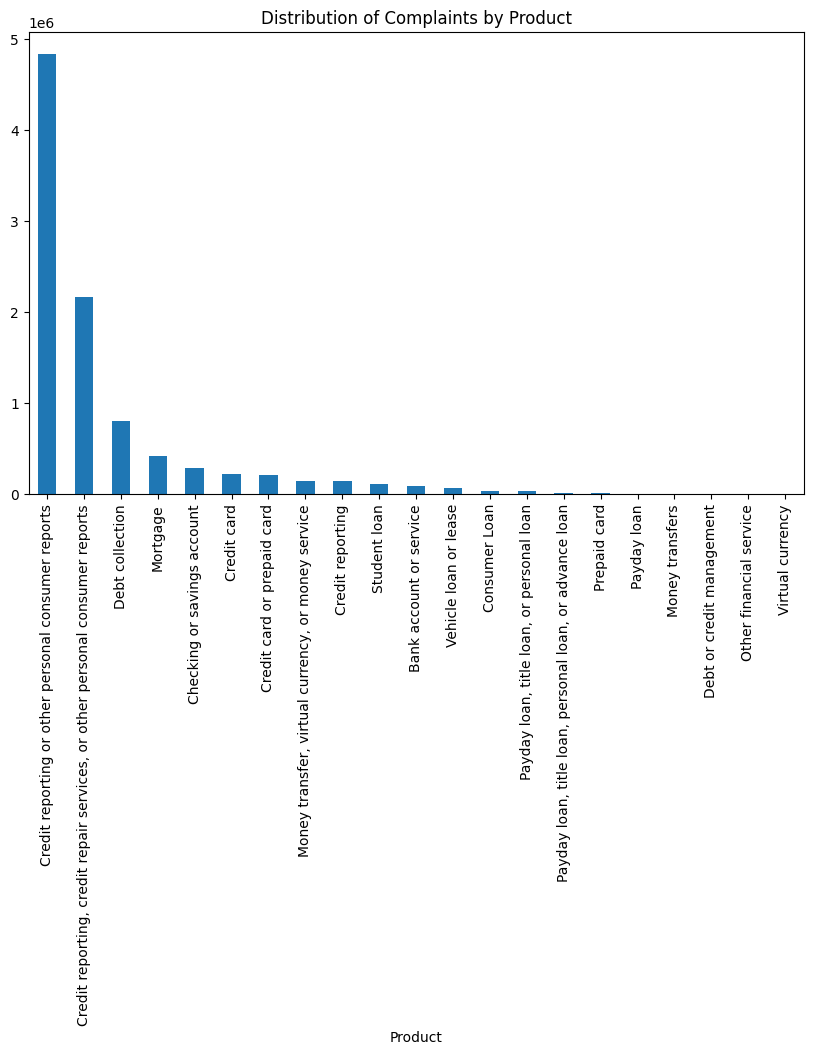

In [5]:
df["Product"].value_counts().plot(kind="bar", figsize=(10, 6))
plt.title("Distribution of Complaints by Product")

<Axes: ylabel='narrative_word_count'>

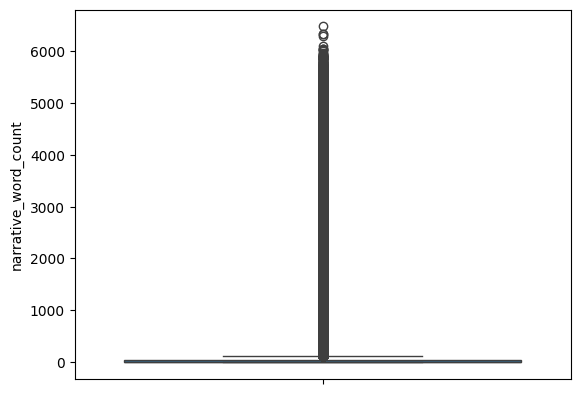

In [6]:
df["narrative_word_count"] = df["Consumer complaint narrative"].apply(lambda x: len(str(x).split()))
sns.boxplot(df["narrative_word_count"])

In [7]:
df.isnull().sum()

Date received                         0
Product                               0
Sub-product                      235295
Issue                                 6
Sub-issue                        839522
Consumer complaint narrative    6629041
Company public response         4770207
Company                               0
State                             54516
ZIP code                          30228
Tags                            8981029
Consumer consent provided?      1649561
Submitted via                         0
Date sent to company                  0
Company response to consumer         20
Timely response?                      0
Consumer disputed?              8841498
Complaint ID                          0
narrative_word_count                  0
dtype: int64

In [8]:
print("Number of complaint without narrative " ,df[df["Consumer complaint narrative"].isnull()].shape)

Number of complaint without narrative  (6629041, 19)


In [9]:
print( "Number of complaint with narrative ", df[ ~(df["Consumer complaint narrative"].isnull())].shape)

Number of complaint with narrative  (2980756, 19)


# Preprocess

* Filter only records for the five specified products: Credit card, Personal loan, Buy Now, Pay Later (BNPL), Savings account, Money transfers.

In [10]:
df= df[(df["Product"] == "Credit card") | (df["Product"] == "Money transfer, virtual currency, or money service") | (df["Product"] == "Payday loan, title loan, or personal loan") | (df["Product"] =="Checking or savings account") | (df["Product"] == "Consumer Loan")]

* Remove any records with empty Consumer complaint narrative fields

In [11]:
df = df[ ~(df["Consumer complaint narrative"].isnull())]

In [12]:
df.isnull().sum()

Date received                        0
Product                              0
Sub-product                      18873
Issue                                0
Sub-issue                       141547
Consumer complaint narrative         0
Company public response         212121
Company                              0
State                             5006
ZIP code                             0
Tags                            287078
Consumer consent provided?           0
Submitted via                        0
Date sent to company                 0
Company response to consumer         0
Timely response?                     0
Consumer disputed?              316575
Complaint ID                         0
narrative_word_count                 0
dtype: int64

* Clean the text narratives

In [13]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

def preprocess(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if not (token.is_stop or token.is_punct or token.like_num or token.like_email or token.like_url)
    ]
    return " ".join(tokens)

In [14]:
df["preprocessed_narrative"] = df["Consumer complaint narrative"].apply(preprocess)

In [15]:
df["preprocessed_narrative"].head()

12237    xxxx xxxx card open fraudster receive notice x...
12532    mistake wellsfargo debit card depsit fund xxxx...
13280    dear cfpb secured credit card citibank change ...
13506    citi reward card credit balance issue $ recent...
13955    b'i write dispute follow charge citi credit ca...
Name: preprocessed_narrative, dtype: object

* Saving the processed data

In [16]:
df.to_csv("../data/processed/complaints_processed.csv", index=False)